### Importing the Dataset

In [2]:
import numpy as np
import pandas as pd
import keras
import json


fp = open("../data/total_posts.json")
posts_data = json.load(fp)
posts = pd.DataFrame.from_dict(posts_data)

2024-06-23 11:55:44.547373: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 11:55:44.548803: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 11:55:44.629954: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 11:55:44.938694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 11:55:46.012302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

FileNotFoundError: [Errno 2] No such file or directory: '../data/total_posts.json'

### Exploring the Dataset

In [2]:
posts

,text,label
0,Today I fucked up at work. I’m not sure if I w...,1
1,The amount of child hate and parent shaming on...,1
2,I don’t know how to convince myself that even...,1
3,Do we know if any of the old SPSF Kodachrome p...,0
4,I told the sunset about you\n\nI told the suns...,1
...,...,...
1836,I’m never sure how to answer the question abou...,1
1837,Just people who have people. They can choose f...,1
1838,"If you could only drink non alcoholic beer, wo...",1
1839,"Hello, I’ve been struggling on and off with br...",1


In [1]:
posts.describe()

NameError: name 'posts' is not defined

### Splitting the Dataset

In [4]:
from sklearn.model_selection import train_test_split


strat_train_set, strat_test_set = train_test_split(posts, test_size=0.2, random_state=42)

#### Analyzing the Dataset

In [5]:
posts = strat_train_set.copy()
posts.head()

,text,label
588,Got Covid for the 2nd time in early October. T...,1
949,2/3/2023\n\nTokophobia\n\nI stare at those lin...,0
1631,I am not implying that I got 100% okay from ju...,1
1719,Omgggggggggggggggg. New song new song new song...,1
1338,My family doesn’t do shit I’m the only boy &am...,1


In [14]:
post_lengths = [len(post.split()) for post in posts["text"]]

In [15]:
post_lengths[:10]

[31, 467, 610, 30, 134, 237, 36, 188, 512, 154]

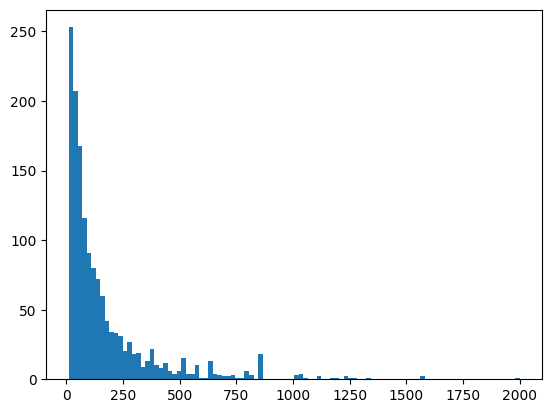

In [20]:
import matplotlib.pyplot as plt

plt.hist(post_lengths, bins=100)
plt.show()

### Building the Classifier

In [33]:
texts = posts[['text']]
labels = posts[['label']]

texts, labels

(                                                   text
 0     Today I fucked up at work. I’m not sure if I w...
 1     The amount of child hate and parent shaming on...
 2      I don’t know how to convince myself that even...
 3     Do we know if any of the old SPSF Kodachrome p...
 4     I told the sunset about you\n\nI told the suns...
 ...                                                 ...
 1836  I’m never sure how to answer the question abou...
 1837  Just people who have people. They can choose f...
 1838  If you could only drink non alcoholic beer, wo...
 1839  Hello, I’ve been struggling on and off with br...
 1840  I've just graduated from university and I'm lo...
 
 [1841 rows x 1 columns],
       label
 0         1
 1         1
 2         1
 3         0
 4         1
 ...     ...
 1836      1
 1837      1
 1838      1
 1839      1
 1840      1
 
 [1841 rows x 1 columns])

#### Tokenizing the posts

In [34]:
from keras_preprocessing.text import Tokenizer       # type: ignore

tokenizer = Tokenizer(num_words=1000, oov_token='<UNK>')
tokenizer.fit_on_texts(texts)

In [40]:
from keras_preprocessing.sequence import pad_sequences

max_len=200

def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len)
    return padded

padded_train_seq = get_sequences(tokenizer, posts)
train_labels = np.array(labels)

#### Creating the model

In [42]:
Sequential = keras.models.Sequential

model = Sequential([
    keras.layers.Embedding(1000, 16),
    keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(20)),
    keras.layers.Dense(2, activation='sigmoid')
])

model.compile(  
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = np.array(val_labels)


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))

print(class_weight_dict)

h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)